Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [5]:
#Set up a dateframes to put the results in

steps_array = np.arange(0, 3001, 50)
import pandas as pd
results_df = pd.DataFrame(
    index = steps_array,
    columns = ['loss', 'train accuracy', 'validation accuracy', 'test accuracy'])
results_df.iloc[0:21]

,loss,train accuracy,validation accuracy,test accuracy
0,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN
150,NaN,NaN,NaN,NaN
200,NaN,NaN,NaN,NaN
250,NaN,NaN,NaN,NaN
300,NaN,NaN,NaN,NaN
350,NaN,NaN,NaN,NaN
400,NaN,NaN,NaN,NaN
450,NaN,NaN,NaN,NaN


Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [6]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

temp_size = image_size // 4 * image_size // 4 * depth

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth,        depth], stddev=0.1))
  layer3_weights = tf.Variable(tf.truncated_normal([temp_size,  num_hidden                     ], stddev=0.1))
  layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels                     ], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv    = tf.nn.conv2d(data,  layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden  = tf.nn.relu(conv + layer1_biases)
    conv    = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden  = tf.nn.relu(conv + layer2_biases)
    shape   = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden  = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [7]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset            = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data        = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels      = train_labels[offset:(offset + batch_size), :]
    feed_dict         = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      results_df['loss'][step] = l
      results_df['train accuracy'][step] = accuracy(predictions, batch_labels)
      results_df['validation accuracy'][step] = accuracy(valid_prediction.eval(), valid_labels)
      results_df['test accuracy'][step] = accuracy(test_prediction.eval(), test_labels)
results_df.iloc[0:21]

Initialized


,loss,train accuracy,validation accuracy,test accuracy
0,2.91001,25,6.77,5.84
50,1.33427,50,48.11,52.31
100,0.467938,87.5,74.12,80.72
150,0.949969,68.75,70.32,77.63
200,0.51635,87.5,75.21,82.55
250,0.13217,100,78.64,85.39
300,0.801987,75,79.6,86.76
350,0.225296,93.75,79.24,86.48
400,0.954472,68.75,79.23,86.27
450,1.06719,75,80.21,87.38


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


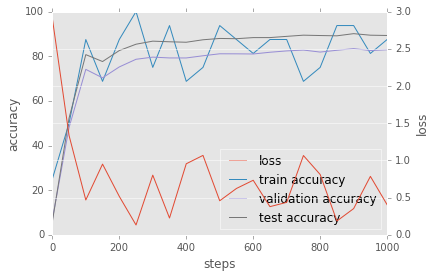

In [8]:
%pylab inline
import matplotlib.pyplot as plt
#import seaborn as sns
matplotlib.style.use('ggplot')

plt.figure()
ax = results_df.iloc[0:21].plot(secondary_y=['loss'], mark_right=False)
ax.set(xlabel='steps', ylabel='accuracy')
ax.right_ax.set_ylabel('loss')

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [9]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

temp_size = image_size // 4 * image_size // 4 * depth

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth,        depth], stddev=0.1))
  layer3_weights = tf.Variable(tf.truncated_normal([temp_size,  num_hidden                     ], stddev=0.1))
  layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels                     ], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv    = tf.nn.conv2d(data,  layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden  = tf.nn.relu(conv + layer1_biases)
    maxpool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    conv    = tf.nn.conv2d(maxpool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden  = tf.nn.relu(conv + layer2_biases)
    maxpool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    shape   = maxpool.get_shape().as_list()
    reshape = tf.reshape(maxpool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden  = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [10]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset            = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data        = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels      = train_labels[offset:(offset + batch_size), :]
    feed_dict         = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      results_df['loss'][step] = l
      results_df['train accuracy'][step] = accuracy(predictions, batch_labels)
      results_df['validation accuracy'][step] = accuracy(valid_prediction.eval(), valid_labels)
      results_df['test accuracy'][step] = accuracy(test_prediction.eval(), test_labels)
results_df.iloc[0:21]

Initialized


,loss,train accuracy,validation accuracy,test accuracy
0,4.2402,12.5,10,10
50,2.30421,18.75,14,14.17
100,2.03156,37.5,17.79,19.2
150,1.57598,50,48.3,52.79
200,0.72449,68.75,72.26,79.35
250,0.311478,87.5,75.05,82.43
300,1.11216,62.5,77.74,84.46
350,0.0733036,100,80.02,86.81
400,0.918813,75,79.41,86.27
450,0.809129,75,79.85,86.39


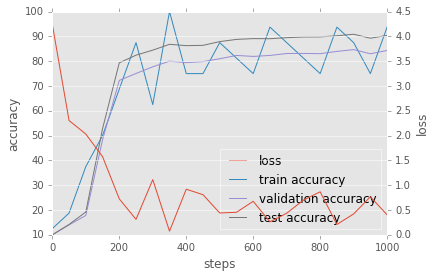

In [11]:
plt.figure()
ax = results_df.iloc[0:21].plot(secondary_y=['loss'], mark_right=False)
ax.set(xlabel='steps', ylabel='accuracy')
ax.right_ax.set_ylabel('loss')

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [12]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
temp_size = image_size // 4 * image_size // 4 * depth

keep_prob = 0.7
l2reg_beta = 0.00001

initial_learning_rate = 0.05
decay_steps = 1000
decay_rate = 0.98

weights1_stdev = 1.0/patch_size/sqrt(num_channels)/keep_prob
weights2_stdev = 1.0/patch_size/sqrt(depth)/keep_prob
weights3_stdev = 1.0/sqrt(temp_size)/keep_prob
weights3_stdev = 1.0/sqrt(num_hidden)/keep_prob

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth,        depth], stddev=0.1))
  layer3_weights = tf.Variable(tf.truncated_normal([temp_size,  num_hidden                     ], stddev=0.1))
  layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels                     ], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
    
  layer2_biases = tf.Variable(tf.zeros([depth]))#constant(1.0, shape=[depth]))
  layer3_biases = tf.Variable(tf.zeros([num_hidden]))#constant(1.0, shape=[num_hidden]))
  layer4_biases = tf.Variable(tf.zeros([num_labels]))#constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data, useDropout=False):
    conv    = tf.nn.conv2d(data,  layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden  = tf.nn.relu(conv + layer1_biases)
    maxpool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    conv    = tf.nn.conv2d(maxpool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden  = tf.nn.relu(conv + layer2_biases)
    maxpool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    shape   = maxpool.get_shape().as_list()
    reshape = tf.reshape(maxpool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden  = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    if useDropout:
        hidden  = tf.nn.dropout(hidden, keep_prob)  
    hidden  = tf.matmul(hidden, layer4_weights) + layer4_biases
    if useDropout:
        hidden  = tf.nn.dropout(hidden, keep_prob)  
    return hidden
  
  # Training computation.
  logits = model(tf_train_dataset, True)
  loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)
                         + l2reg_beta*(tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) +
                                       tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights)) )

  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay( initial_learning_rate, global_step, decay_steps, decay_rate,
                                              staircase=True )
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [13]:
num_steps = 1501

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset            = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data        = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels      = train_labels[offset:(offset + batch_size), :]
    feed_dict         = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      results_df['loss'][step] = l
      results_df['train accuracy'][step] = accuracy(predictions, batch_labels)
      results_df['validation accuracy'][step] = accuracy(valid_prediction.eval(), valid_labels)
      results_df['test accuracy'][step] = accuracy(test_prediction.eval(), test_labels)
results_df.iloc[0:31]

Initialized


,loss,train accuracy,validation accuracy,test accuracy
0,2.3459,18.75,9.51,9.39
50,1.95093,37.5,34.74,37.9
100,1.12078,62.5,69.42,76.24
150,1.21331,56.25,73.83,80.75
200,1.23442,50,75.41,82.44
250,0.857636,75,78.86,85.59
300,1.33213,56.25,79.39,86.29
350,0.672646,75,79.79,86.15
400,1.16502,56.25,80.94,87.52
450,1.13808,62.5,80.47,86.8


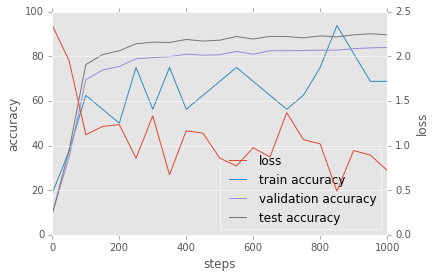

In [14]:
plt.figure()
ax = results_df.iloc[0:21].plot(secondary_y=['loss'], mark_right=False)
ax.set(xlabel='steps', ylabel='accuracy')
ax.right_ax.set_ylabel('loss')